In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_recall_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Primeramente cargamos el dataframe de las reviews

In [2]:
data=pd.read_csv('steam_reseñas.csv')
data_aum=pd.read_csv('steam_reseñas_aumentadas.csv')

## Dropeamos los Nan para la prueba

In [3]:
print(data.isna().sum())
data_clean=data.dropna()
data_aum_clean=data_aum.dropna()

game_title             0
game_id                0
review                 0
recommended            0
no_stopwords           4
clean_text             4
lemmatized_text        4
lemmatized_text_v2    92
dtype: int64


In [4]:
print(data_clean.isna().sum())
print(data_aum_clean.isna().sum())

game_title            0
game_id               0
review                0
recommended           0
no_stopwords          0
clean_text            0
lemmatized_text       0
lemmatized_text_v2    0
dtype: int64
game_title            0
game_id               0
review                0
recommended           0
no_stopwords          0
clean_text            0
lemmatized_text       0
lemmatized_text_v2    0
dtype: int64


## Ahora vamos a ver si las clases están balanceadas

In [5]:
print(data_clean['recommended'].value_counts())
print(data_aum_clean['recommended'].value_counts())

recommended
True     8807
False    1105
Name: count, dtype: int64
recommended
True     8807
False    6105
Name: count, dtype: int64


Como vemos las clases no están balanceadas, luego es preciso tener en cuenta esto a la hora de realizar los modelos para no emplear el umbral básico de sklearn y añadir en la estratificación de los datos este hecho para intentar que los conjuntos sean lo más homogéneos posible.

## Modelos

In [6]:
data_clean

,game_title,game_id,review,recommended,no_stopwords,clean_text,lemmatized_text,lemmatized_text_v2
0,Counter-Strike 2,730,juego de mierd4 te odio si un dia un amigo les...,True,juego mierd4 odio si dia amigo dice jueguen di...,juego mierd4 odio si dia amigo dice jueguen di...,juego mierd4 odiar si dia amigo decir jugar di...,mierd4 odiar dia amigo decir directamente bloq...
1,Counter-Strike 2,730,"Buen juego, es sorprendente la cantidad de ins...",True,buen juego sorprendente cantidad insultos crea...,buen juego sorprendente cantidad insultos crea...,buen juego sorprendente cantidad insulto creat...,sorprendente cantidad insulto creativo encontr...
2,Counter-Strike 2,730,"Este juego del diablo te deja: sin plata, sin ...",True,juego diablo deja plata amigos pareja futuro p...,juego diablo deja plata amigos pareja futuro p...,juego diablo dejar plata amigo parejo futuro p...,diablo dejar plata amigo parejo futuro platar ...
3,Counter-Strike 2,730,"El juego esta bien, el tema son los hackers qu...",True,juego bien tema hackers joden incluso premier ...,juego bien tema hackers joden incluso premier ...,juego bien tema hackers joden incluso premier ...,bien tema hackers joden incluso premier empare...
4,Counter-Strike 2,730,"10/10, racismo y degeneración a raudales. Si o...",True,1010 racismo degeneración raudales si odias vi...,1010 racismo degeneracion raudales si odias vi...,1010 racismo degeneracion raudal si odiar vida...,1010 racismo degeneracion raudal odiar vida pr...
...,...,...,...,...,...,...,...,...
9999,Call of Duty®: Modern Warfare® 2 (2009),10180,Es un juegazo lo recomiendo,True,juegazo recomiendo,juegazo recomiendo,juegazo recomeir,juegazo recomeir
10000,Call of Duty®: Modern Warfare® 2 (2009),10180,Buen juego para recordar viejas glorias,True,buen juego recordar viejas glorias,buen juego recordar viejas glorias,buen juego recordar viejo gloria,recordar viejo gloria
10001,Call of Duty®: Modern Warfare® 2 (2009),10180,es el mejor juego,True,mejor juego,mejor juego,mejor juego,mejor
10002,Call of Duty®: Modern Warfare® 2 (2009),10180,mejor que el sexo,True,mejor sexo,mejor sexo,mejor sexo,mejor sexo


Empezamos empleando como vectorizador el bag of words y como modelos de prueba emplearemos uno de los más sencillos que será la regresión logística y luego con otro más complejo el XGBoost.

In [43]:
def eval_model_with_data(vectorizer, clf, data_clean):
    # Filtrar datos sintéticos
    real_mask = data_clean['game_id'] != 0

    X_real = data_clean.loc[real_mask, 'lemmatized_text_v2']
    y_real = data_clean.loc[real_mask, 'recommended']

    X_aug = data_clean.loc[~real_mask, 'lemmatized_text_v2']
    y_aug = data_clean.loc[~real_mask, 'recommended']

    # Dividir solo los datos reales
    X_train_real, X_test, y_train_real, y_test = train_test_split(
        X_real, y_real, test_size=0.2, random_state=42, stratify=y_real
    )

    # Añadir los sintéticos solo al train
    X_train = pd.concat([X_train_real, X_aug])
    y_train = pd.concat([y_train_real, y_aug])


    # 3. Vectoriza los textos (Bag of Words)
    
    X_train_bow = vectorizer.fit_transform(X_train)
    X_test_bow = vectorizer.transform(X_test)

    # 4. Entrena un modelo de regresión logística
    
    clf.fit(X_train_bow, y_train)

    # 5. Predice probabilidades
    y_proba = clf.predict_proba(X_test_bow)[:, 1]  # Probabilidad de clase positiva

    # 6. Evalúa F1 con distintos umbrales
    thresh = np.arange(0.1, 0.9, 0.05)
    f1s = [f1_score(y_test, y_proba >= t) for t in thresh]
    f1sN = [f1_score(1-y_test, y_proba < t) for t in thresh]

    # Encuentra el umbral con mejor F1
    max_f1 = max(f1s)
    best_thresh = thresh[f1s.index(max_f1)]
    print(f"\n>> Mejor F1-score: {max_f1:.4f} con umbral: {best_thresh:.2f}")

    # Encuentra el umbral con mejor F1 para clase complementaria

    max_f1N = max(f1sN)
    best_threshN = thresh[f1sN.index(max_f1N)]
    print(f"\n>> Mejor F1-score para el complementario: {max_f1N:.4f} con umbral: {best_threshN:.2f}")

    # Encuentra el umbral con mejor F1 general: (ponderando por la relevancia de las clases en el conjunto test)

    supp_0, supp_1 = np.sum(y_test == 0)/len(y_test), np.sum(y_test == 1)/len(y_test)
    f1_pond = supp_1 * np.array(f1s) + supp_0 * np.array(f1sN)
    max_f1_pond = np.max(f1_pond)
    
    best_thresh_all = thresh[np.argmax(f1_pond)]

    print(f"\n>> Mejor F1-score ponderado: {max_f1_pond:.4f} con umbral: {best_thresh_all:.2f}")


    # 7. Reporte de clasificación para el mejor umbral
    y_pred_best = (y_proba >= best_thresh_all)
    print("\n>> Classification Report con mejor umbral (ponderado):")
    print(classification_report(y_test, y_pred_best))

    # Crear figura con 3 subplots en horizontal
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))

    # --- 1. Matriz de Confusión ---
    cm = confusion_matrix(y_test, y_pred_best)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
    disp.plot(ax=axs[0], cmap='Blues', colorbar=False)
    axs[0].set_title(f'Matriz de Confusión\n(Umbral óptimo = {best_thresh_all:.2f})')
    axs[0].grid(False)

    # --- 2. F1 vs Umbral ---
    axs[1].plot(thresh, f1s, color ='red', label='F1 Score')
    axs[1].plot(thresh, f1sN, label='F1N Score')
    axs[1].plot(thresh, f1_pond, color = 'green', label='weighted F1 Score')
    axs[1].axvline(x=best_thresh, color='red', linestyle='--', label=f'Máx F1 = {max_f1:.4f}')
    axs[1].axvline(x=best_threshN, color='blue', linestyle='--', label=f'Máx F1N = {max_f1N:.4f}')
    axs[1].axvline(x=best_thresh_all, color='green', linestyle='--', label=f'Máx weighted F1 = {max_f1_pond:.4f}')
    axs[1].scatter(best_thresh, max_f1, color='red')
    axs[1].scatter(best_threshN, max_f1N, color='blue')
    axs[1].scatter(best_thresh_all, max_f1_pond, color='green')
    axs[1].set_xlabel("Umbral")
    axs[1].set_ylabel("F1 Score")
    axs[1].set_title("F1 vs Umbral")
    axs[1].legend()
    axs[1].grid(True)

    # --- 3. Precisión y Recall vs Umbral ---
    precision, recall, thresh_pr = precision_recall_curve(y_test, y_proba)
    axs[2].plot(thresh_pr, precision[:-1], label='Precisión')
    axs[2].plot(thresh_pr, recall[:-1], label='Recall')
    axs[2].set_xlabel('Umbral')
    axs[2].set_ylabel('Valor')
    axs[2].set_title('Precisión y Recall vs Umbral')
    axs[2].legend()
    axs[2].grid(True)

    # Ajustar espacios
    plt.tight_layout()
    plt.show()
            



 Estudio con datos originales para BoW + LogisticRegression:

>> Mejor F1-score: 0.9494 con umbral: 0.35

>> Mejor F1-score para el complementario: 0.5782 con umbral: 0.80

>> Mejor F1-score ponderado: 0.9048 con umbral: 0.70

>> Classification Report con mejor umbral (ponderado):
              precision    recall  f1-score   support

       False       0.58      0.56      0.57       221
        True       0.94      0.95      0.95      1762

    accuracy                           0.91      1983
   macro avg       0.76      0.75      0.76      1983
weighted avg       0.90      0.91      0.90      1983



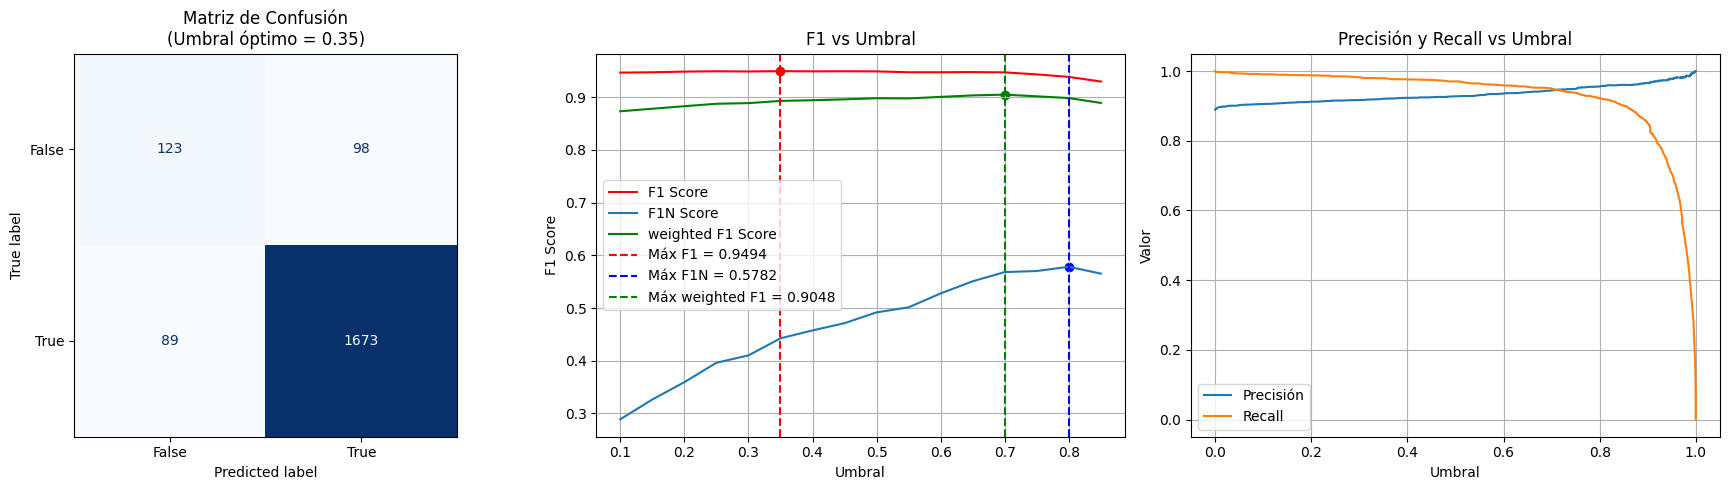



 Estudio con datos aumentados para BoW + LogisticRegression:

>> Mejor F1-score: 0.9624 con umbral: 0.15

>> Mejor F1-score para el complementario: 0.6792 con umbral: 0.20

>> Mejor F1-score ponderado: 0.9301 con umbral: 0.20

>> Classification Report con mejor umbral (ponderado):
              precision    recall  f1-score   support

       False       0.71      0.65      0.68       221
        True       0.96      0.97      0.96      1762

    accuracy                           0.93      1983
   macro avg       0.83      0.81      0.82      1983
weighted avg       0.93      0.93      0.93      1983



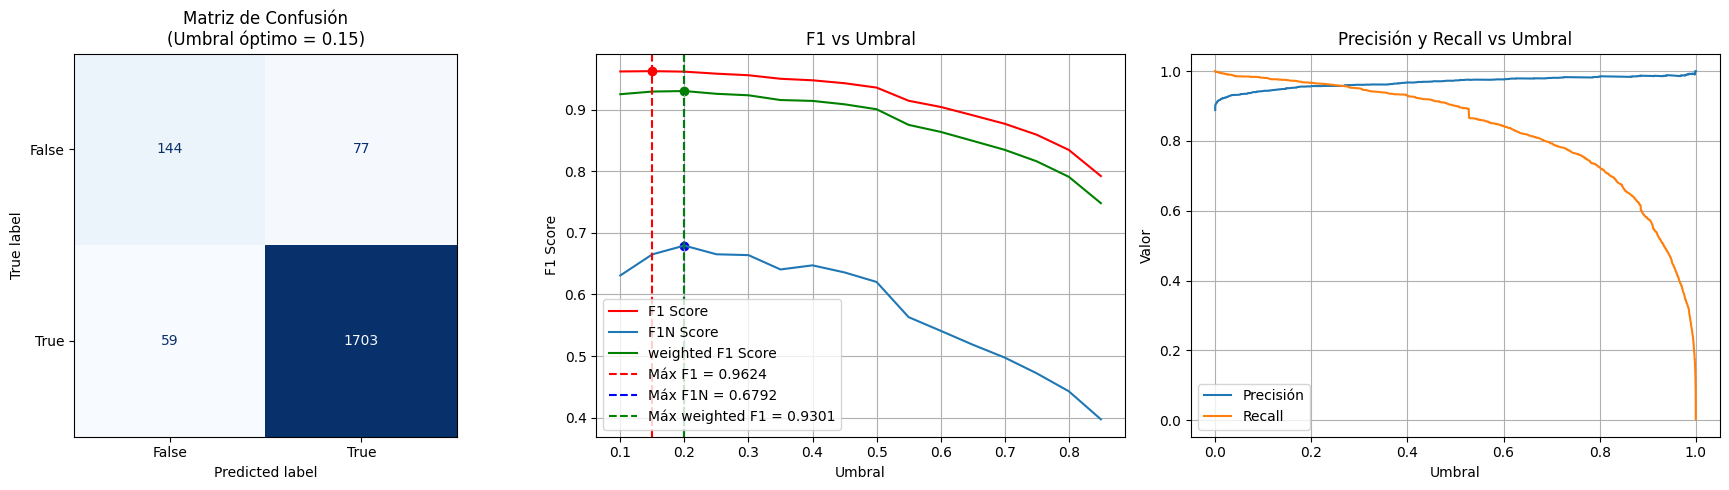

In [30]:
BoW_vectorizer = CountVectorizer(max_features=2000)
clf = LogisticRegression(max_iter=1000, solver='liblinear')  # mejor para estabilidad

print('\n\n Estudio con datos originales para BoW + LogisticRegression:')
eval_model_with_data(BoW_vectorizer,clf,data_clean)

print('\n\n Estudio con datos aumentados para BoW + LogisticRegression:')
eval_model_with_data(BoW_vectorizer,clf,data_aum_clean)

Ahora vamos a probar con el XGBoost



 Estudio con datos originales para BoW + XGBClassifier:

>> Mejor F1-score: 0.9530 con umbral: 0.55

>> Mejor F1-score para el complementario: 0.5872 con umbral: 0.80

>> Mejor F1-score ponderado: 0.9061 con umbral: 0.75

>> Classification Report con mejor umbral (ponderado):
              precision    recall  f1-score   support

       False       0.59      0.55      0.57       221
        True       0.94      0.95      0.95      1762

    accuracy                           0.91      1983
   macro avg       0.77      0.75      0.76      1983
weighted avg       0.90      0.91      0.91      1983



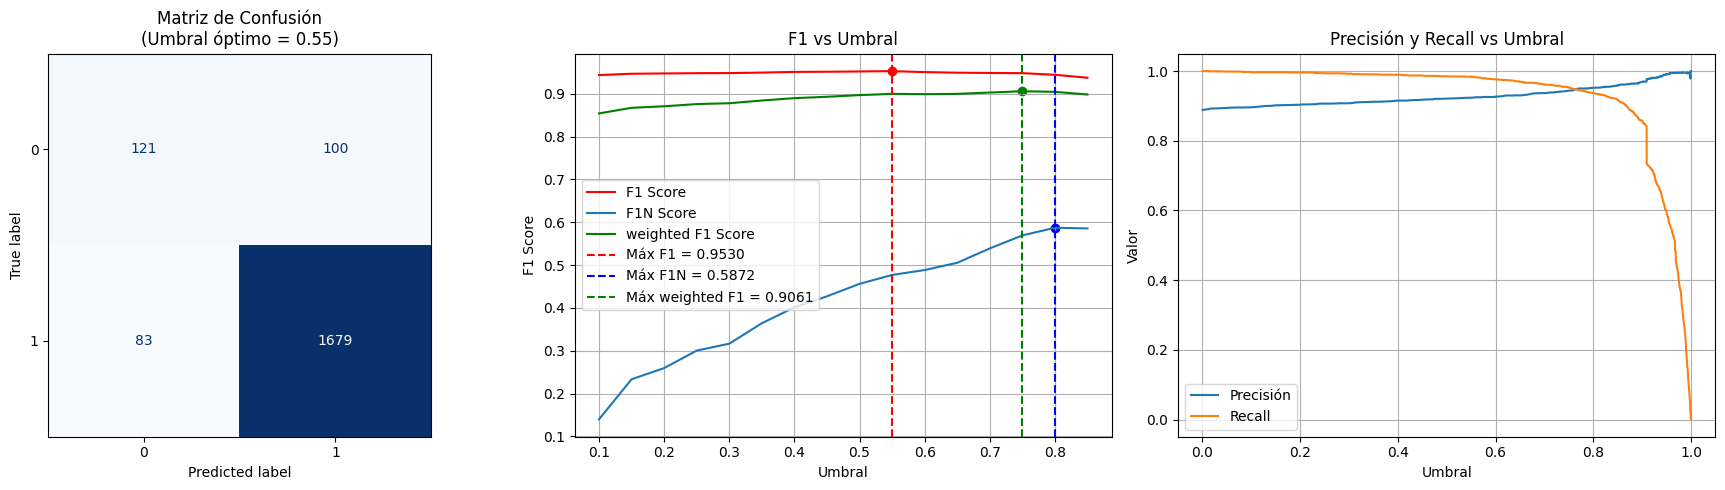



 Estudio con datos aumentados para BoW + XGBClassifier:

>> Mejor F1-score: 0.9575 con umbral: 0.25

>> Mejor F1-score para el complementario: 0.6398 con umbral: 0.40

>> Mejor F1-score ponderado: 0.9190 con umbral: 0.35

>> Classification Report con mejor umbral (ponderado):
              precision    recall  f1-score   support

       False       0.63      0.64      0.64       221
        True       0.96      0.95      0.95      1762

    accuracy                           0.92      1983
   macro avg       0.79      0.80      0.80      1983
weighted avg       0.92      0.92      0.92      1983



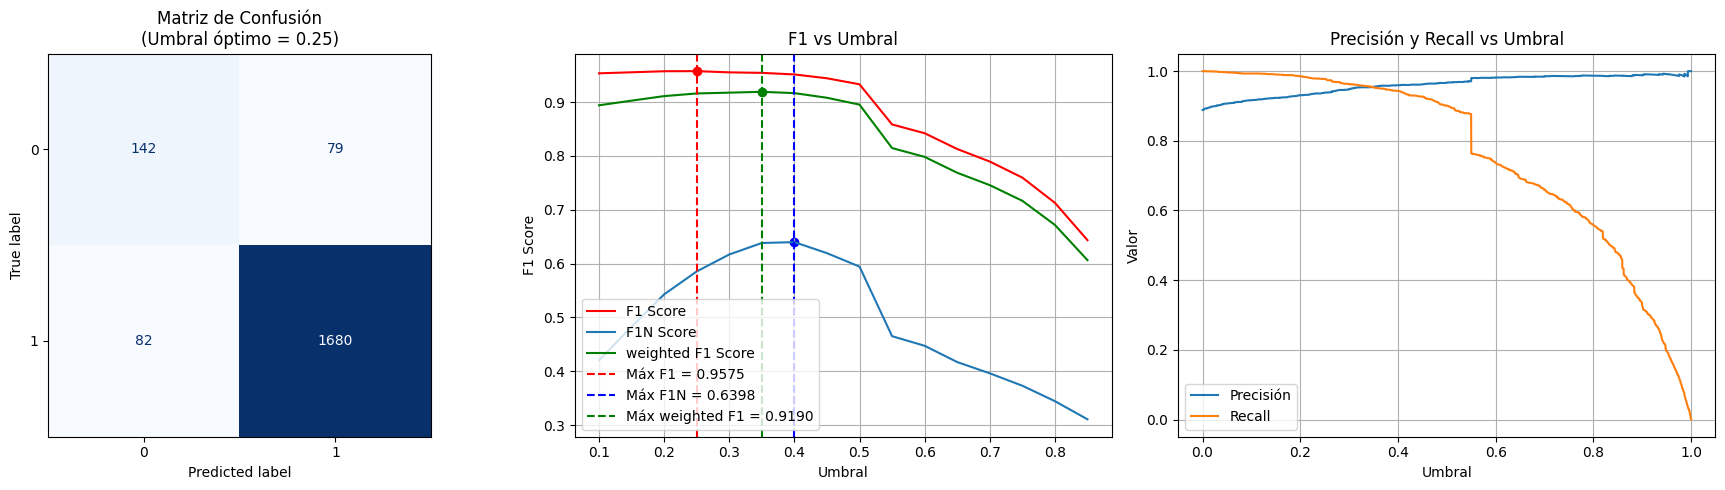

In [ ]:
from xgboost import XGBClassifier 

# 4. Entrena modelo XGBoost
clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss', verbosity=0)
BoW_vectorizer = CountVectorizer(max_features=2000)

print('\n\n Estudio con datos originales para BoW + XGBClassifier:')
eval_model_with_data(BoW_vectorizer,clf,data_clean)

print('\n\n Estudio con datos aumentados para BoW + XGBClassifier:')
eval_model_with_data(BoW_vectorizer,clf,data_aum_clean)

## Ahora vamos a emplear tfidf como vectorizador



 Estudio con datos originales para TFIDF + Logistic regression:

>> Mejor F1-score: 0.9576 con umbral: 0.65

>> Mejor F1-score para el complementario: 0.6019 con umbral: 0.75

>> Mejor F1-score ponderado: 0.9146 con umbral: 0.65

>> Classification Report con mejor umbral (ponderado):
              precision    recall  f1-score   support

       False       0.75      0.46      0.57       221
        True       0.94      0.98      0.96      1762

    accuracy                           0.92      1983
   macro avg       0.84      0.72      0.76      1983
weighted avg       0.91      0.92      0.91      1983



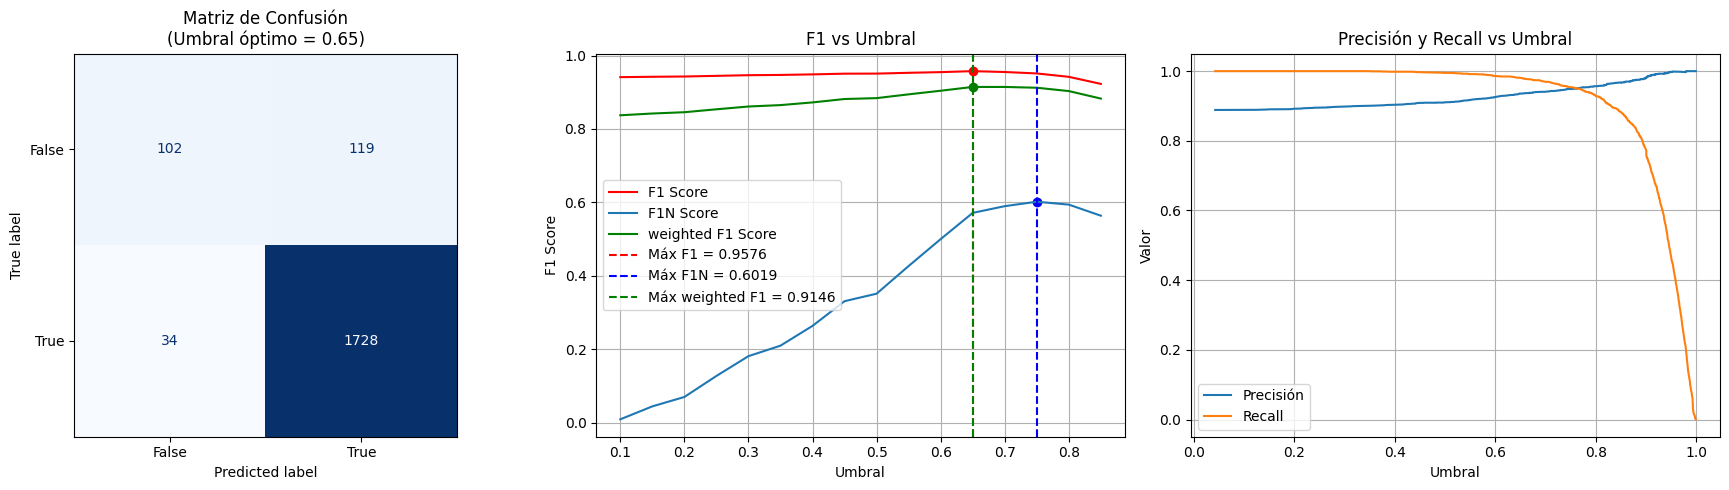



 Estudio con datos aumentados para TFIDF + Logistic regression:

>> Mejor F1-score: 0.9603 con umbral: 0.20

>> Mejor F1-score para el complementario: 0.6497 con umbral: 0.35

>> Mejor F1-score ponderado: 0.9230 con umbral: 0.25

>> Classification Report con mejor umbral (ponderado):
              precision    recall  f1-score   support

       False       0.72      0.57      0.63       221
        True       0.95      0.97      0.96      1762

    accuracy                           0.93      1983
   macro avg       0.83      0.77      0.80      1983
weighted avg       0.92      0.93      0.92      1983



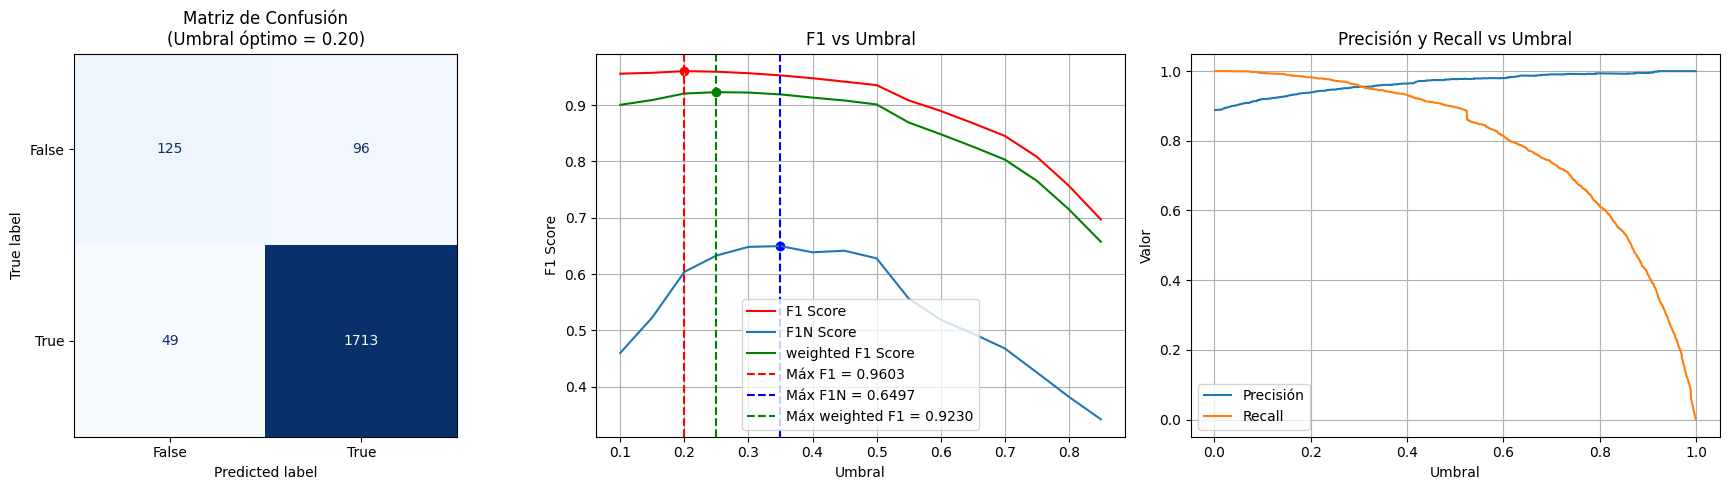

In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer

# 3. Vectoriza con TF-IDF
TFIDFvectorizer = TfidfVectorizer(max_features=2000)
clf = LogisticRegression(max_iter=1000, solver='liblinear')  # mejor para estabilidad

print('\n\n Estudio con datos originales para TFIDF + Logistic regression:')
eval_model_with_data(TFIDFvectorizer,clf,data_clean)

print('\n\n Estudio con datos aumentados para TFIDF + Logistic regression:')
eval_model_with_data(TFIDFvectorizer,clf,data_aum_clean)



 Estudio con datos originales para TFIDF + Logistic regression:

>> Mejor F1-score: 0.9530 con umbral: 0.55

>> Mejor F1-score para el complementario: 0.5872 con umbral: 0.80

>> Mejor F1-score ponderado: 0.9061 con umbral: 0.75

>> Classification Report con mejor umbral (ponderado):
              precision    recall  f1-score   support

       False       0.59      0.55      0.57       221
        True       0.94      0.95      0.95      1762

    accuracy                           0.91      1983
   macro avg       0.77      0.75      0.76      1983
weighted avg       0.90      0.91      0.91      1983



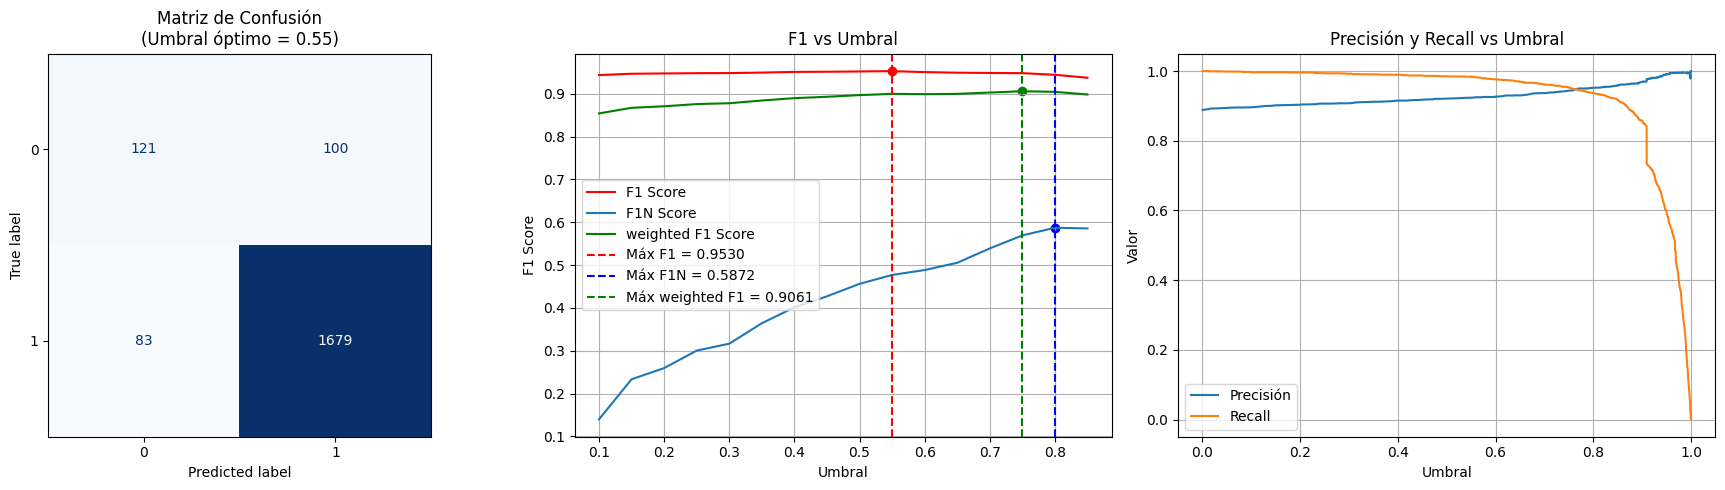



 Estudio con datos aumentados para TFIDF + Logistic regression:

>> Mejor F1-score: 0.9575 con umbral: 0.25

>> Mejor F1-score para el complementario: 0.6398 con umbral: 0.40

>> Mejor F1-score ponderado: 0.9190 con umbral: 0.35

>> Classification Report con mejor umbral (ponderado):
              precision    recall  f1-score   support

       False       0.63      0.64      0.64       221
        True       0.96      0.95      0.95      1762

    accuracy                           0.92      1983
   macro avg       0.79      0.80      0.80      1983
weighted avg       0.92      0.92      0.92      1983



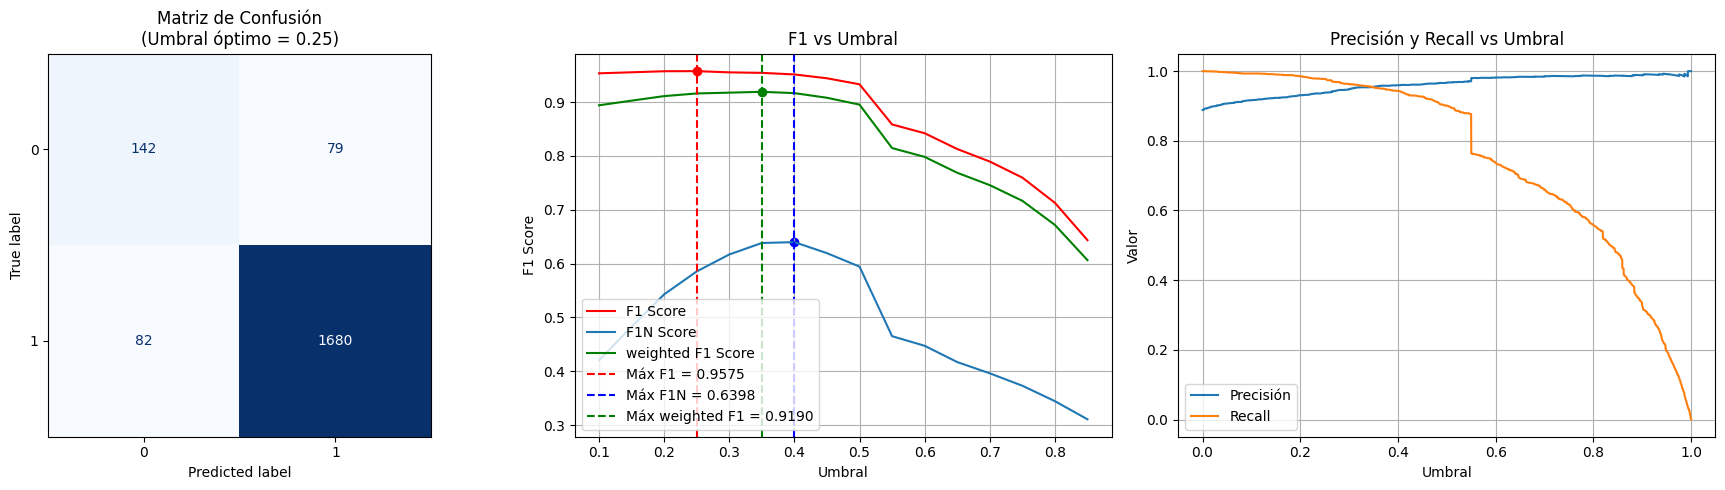

In [ ]:
clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss', verbosity=0)
TFIDFvectorizer = TfidfVectorizer(max_features=2000)

print('\n\n Estudio con datos originales para TFIDF + Logistic regression:')
eval_model_with_data(TFIDFvectorizer,clf,data_clean)

print('\n\n Estudio con datos aumentados para TFIDF + Logistic regression:')
eval_model_with_data(TFIDFvectorizer,clf,data_aum_clean)

En general es evidente que el uso de datos aumentados aumenta considerablemente el f1 del complementario y además esto sin sacrificar el valor del f1 de la etiqueta original.

In [34]:
%pip install tabulate

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [41]:
from tabulate import tabulate
# Configuraciones a evaluar
vectorizers = {
    "CountVectorizer": CountVectorizer(max_features=2000),
    "TfidfVectorizer": TfidfVectorizer(max_features=2000)
}

models = {
    "LogisticRegression": LogisticRegression(max_iter=1000, solver='liblinear'),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', verbosity=0)
}

# Evaluación
resultados = []

for vec_name, vectorizer in vectorizers.items():
    real_mask = data_aum_clean['game_id'] != 0

    X_real = data_aum_clean.loc[real_mask, 'lemmatized_text_v2']
    y_real = data_aum_clean.loc[real_mask, 'recommended']

    X_aug = data_aum_clean.loc[~real_mask, 'lemmatized_text_v2']
    y_aug = data_aum_clean.loc[~real_mask, 'recommended']

    # Dividir solo los datos reales
    X_train_real, X_test, y_train_real, y_test = train_test_split(
        X_real, y_real, test_size=0.2, random_state=42, stratify=y_real
    )

    # Añadir los sintéticos solo al train
    X_train = pd.concat([X_train_real, X_aug])
    y_train = pd.concat([y_train_real, y_aug])

    X_train_vec = vectorizer.fit_transform(X_train)
    X_test_vec = vectorizer.transform(X_test)
    
    for model_name, model in models.items():
        model.fit(X_train_vec, y_train)
        y_proba = model.predict_proba(X_test_vec)[:, 1]

        # 6. Evalúa F1 con distintos umbrales
        thresh = np.arange(0.1, 0.9, 0.05)
        f1s = [f1_score(y_test, y_proba >= t) for t in thresh]
        f1sN = [f1_score(1-y_test, y_proba < t) for t in thresh]

        # Encuentra el umbral con mejor F1
        max_f1 = max(f1s)
        best_thresh = thresh[f1s.index(max_f1)]

        # Encuentra el umbral con mejor F1 para clase complementaria

        max_f1N = max(f1sN)
        best_threshN = thresh[f1sN.index(max_f1N)]

        # Encuentra el umbral con mejor F1 general: (ponderando por la relevancia de las clases en el conjunto test)

        supp_0, supp_1 = np.sum(y_test == 0)/len(y_test), np.sum(y_test == 1)/len(y_test)
        f1_pond = supp_1 * np.array(f1s) + supp_0 * np.array(f1sN)
        max_f1_pond = np.max(f1_pond)
        
        best_thresh_all = thresh[np.argmax(f1_pond)]

        # Guardar resultado
        resultados.append({
            "Modelo": model_name,
            "Vectorizador": vec_name,
            "F1-score": round(max_f1_pond, 4),
            "Umbral óptimo": round(best_thresh_all, 2)
        })

# Crear DataFrame
df_resultados = pd.DataFrame(resultados)


# Mostrar la tabla con formato bonito
tabla_bonita = tabulate(df_resultados, headers='keys', tablefmt='fancy_grid', showindex=False)
print(tabla_bonita)

╒════════════════════╤═════════════════╤════════════╤═════════════════╕
│ Modelo             │ Vectorizador    │   F1-score │   Umbral óptimo │
╞════════════════════╪═════════════════╪════════════╪═════════════════╡
│ LogisticRegression │ CountVectorizer │     0.9301 │            0.2  │
├────────────────────┼─────────────────┼────────────┼─────────────────┤
│ XGBoost            │ CountVectorizer │     0.919  │            0.35 │
├────────────────────┼─────────────────┼────────────┼─────────────────┤
│ LogisticRegression │ TfidfVectorizer │     0.923  │            0.25 │
├────────────────────┼─────────────────┼────────────┼─────────────────┤
│ XGBoost            │ TfidfVectorizer │     0.9136 │            0.25 │
╘════════════════════╧═════════════════╧════════════╧═════════════════╛


## Vamos a intentar emplear un detector automático de ironías para intentar detectar los casos en los que las reseñas tienen un contenido irónico

In [42]:
%pip install peft

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 83.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 87.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 74.9 MB/s eta 0:00:00
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from peft import PeftModel, PeftConfig
import torch

# Primero cargas la configuración del adapter
adapter_model = "TransferGraph/JonatanGk_roberta-base-bne-finetuned-cyberbullying-spanish-finetuned-lora-tweet_eval_irony"
config = PeftConfig.from_pretrained(adapter_model)

# Cargas el modelo base (sobre el que se entrenó el LoRA)
base_model = AutoModelForSequenceClassification.from_pretrained(config.base_model_name_or_path)

# Aplicar el adapter LoRA
irony_model = PeftModel.from_pretrained(base_model, adapter_model)

# Tokenizer del modelo base
tokenizer = AutoTokenizer.from_pretrained(config.base_model_name_or_path)

# Mover a dispositivo
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
irony_model.to(device)

/home/codespace/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): RobertaForSequenceClassification(
      (roberta): RobertaModel(
        (embeddings): RobertaEmbeddings(
          (word_embeddings): Embedding(50262, 768, padding_idx=1)
          (position_embeddings): Embedding(514, 768, padding_idx=1)
          (token_type_embeddings): Embedding(1, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (encoder): RobertaEncoder(
          (layer): ModuleList(
            (0-11): 12 x RobertaLayer(
              (attention): RobertaAttention(
                (self): RobertaSdpaSelfAttention(
                  (query): lora.Linear(
                    (base_layer): Linear(in_features=768, out_features=768, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.1, inplace=False)
                    )
                    (lora_A): Mod

## función de detección

In [ ]:
from tqdm import tqdm

def detectar_ironia(textos, batch_size=16):
    irony_scores = []
    irony_model.eval()  # aseguramos modo inferencia
    for i in tqdm(range(0, len(textos), batch_size), desc="Detectando ironía"):
        batch = textos[i:i+batch_size]
        inputs = tokenizer(batch, padding=True, truncation=True, return_tensors="pt", max_length=128)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        
        with torch.no_grad():
            outputs = irony_model(**inputs)
            probs = torch.softmax(outputs.logits, dim=1)[:, 1]  # probabilidad de ironía
            irony_scores.extend(probs.cpu().numpy())
    return np.array(irony_scores)

Aplicamos la función

In [ ]:
# Asegúrate de que X_train y X_test sean listas de strings
ironia_train = detectar_ironia(X_train.tolist())
ironia_test = detectar_ironia(X_test.tolist())

Detectando ironía: 100%|██████████| 176/176 [06:43<00:00,  2.29s/it]


Vemos que tal funciona

In [ ]:
for i in range(10):
    print(f"📝 Review {i+1}: {X_train.values[i]}")
    print(f"✅ Etiqueta (recommended): {y_train.values[i]}")
    print(f"🎭 Probabilidad de ironía: {round(ironia_train[i], 4)}")
    print("-" * 80)

📝 Review 1: Es un juego en el que donde te guste minimamente los dinosaurios y la supervivencia, le vas a meter una viciada increible, engancha muchisimo, me atrevo a decir que es uno de los mejores juegos que nos daria esta experiencia dino-survival (sino el mejor). es disfrutable y si le agregas mods, provecho, no son precisamente pocos los que tiene, y muchos de ellos son una ampliacion enorme al juego para que tengas mas contenido si es lo que buscas.
Su mayor fallo es la optimizacion, pero si puedes correrlo, lo disfrutaras
✅ Etiqueta (recommended): True
🎭 Probabilidad de ironía: 0.5033000111579895
--------------------------------------------------------------------------------
📝 Review 2: DE 1 a 10 (UN 10)
✅ Etiqueta (recommended): True
🎭 Probabilidad de ironía: 0.3889000117778778
--------------------------------------------------------------------------------
📝 Review 3: No hay servidores en linea
✅ Etiqueta (recommended): False
🎭 Probabilidad de ironía: 0.2761000096797943
-----

Aplicamos la pipeline

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from scipy.sparse import hstack, csr_matrix

# === VECTORIZADORES Y MODELOS ===
vectorizers = {
    "CountVectorizer": CountVectorizer(max_features=2000),
    "TfidfVectorizer": TfidfVectorizer(max_features=2000)
}

models = {
    "LogisticRegression": LogisticRegression(max_iter=1000, solver='liblinear'),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', verbosity=0)
}

# === EVALUACIÓN CON IRONÍA COMO FEATURE ===
resultados = []

for vec_name, vectorizer in vectorizers.items():
    X_train_vec = vectorizer.fit_transform(X_train)
    X_test_vec = vectorizer.transform(X_test)

    # Añadir ironía como feature adicional
    X_train_final = hstack([X_train_vec, ironia_train])
    X_test_final = hstack([X_test_vec, ironia_test])

    for model_name, model in models.items():
        model.fit(X_train_final, y_train)
        y_proba = model.predict_proba(X_test_final)[:, 1]

        # Buscar mejor umbral según F1
        thresholds = np.arange(0.1, 0.9, 0.05)
        f1s = [f1_score(y_test, y_proba >= t) for t in thresholds]
        best_f1 = max(f1s)
        best_thresh = thresholds[f1s.index(best_f1)]

        resultados.append({
            "Modelo": model_name,
            "Vectorizador": vec_name + " + Ironía",
            "F1-score": round(best_f1, 4),
            "Umbral óptimo": round(best_thresh, 2)
        })

# === MOSTRAR RESULTADOS ===
df_resultados = pd.DataFrame(resultados)
tabla_bonita = tabulate(df_resultados, headers='keys', tablefmt='fancy_grid', showindex=False)
print(tabla_bonita)


ValueError: blocks[0,:] has incompatible row dimensions. Got blocks[0,1].shape[0] == 1, expected 11241.

## Vamos a probar a hacer el análisis con un modelo de análisis de sentimientos 

Empleamos un modelo híbrido con análisis de sentimientos y la ironía para luego entrenar con ellos un clasificador básico

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import numpy as np
from tqdm import tqdm

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

model_name = "tabularisai/multilingual-sentiment-analysis"
tokenizer = AutoTokenizer.from_pretrained(model_name)
sentiment_model = AutoModelForSequenceClassification.from_pretrained(model_name).to(device)
sentiment_model.eval()

def obtener_probas_sentimiento(textos, batch_size=16):
    probas = []
    for i in tqdm(range(0, len(textos), batch_size), desc="Obteniendo probas sentimiento"):
        batch = textos[i:i+batch_size]
        inputs = tokenizer(batch, padding=True, truncation=True, return_tensors="pt", max_length=128)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        
        with torch.no_grad():
            outputs = sentiment_model(**inputs)
            probs = torch.softmax(outputs.logits, dim=1).cpu().numpy()  # shape: (B, 3)
            probas.extend(probs)
    
    return np.array(probas)  # shape: (N, 3)

2. Predecir las probabilidades

In [ ]:
# Obtenemos [negativo, neutro, positivo]
probas_train = obtener_probas_sentimiento(X_train.tolist())
probas_test = obtener_probas_sentimiento(X_test.tolist())

# Escogemos solo la probabilidad de positivo
proba_pos_train = probas_train[:, 2].reshape(-1, 1)
proba_pos_test = probas_test[:, 2].reshape(-1, 1)

# Concatenamos con la probabilidad de ironía (que ya tienes)
X_train_final = np.hstack([proba_pos_train, ironia_train.reshape(-1, 1)])
X_test_final = np.hstack([proba_pos_test, ironia_test.reshape(-1, 1)])

Obteniendo probas sentimiento: 100%|██████████| 176/176 [00:07<00:00, 22.90it/s]


3. Entrenamos el modelo híbrido

In [ ]:
from xgboost import XGBClassifier

modelo_final = XGBClassifier(use_label_encoder=False, eval_metric='logloss', verbosity=0)
modelo_final.fit(X_train_final, y_train)
y_pred = modelo_final.predict(X_test_final)

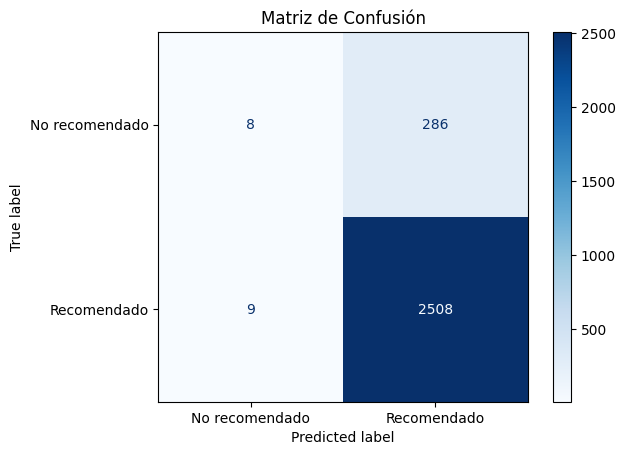

                precision    recall  f1-score   support

No recomendado       0.47      0.03      0.05       294
   Recomendado       0.90      1.00      0.94      2517

      accuracy                           0.90      2811
     macro avg       0.68      0.51      0.50      2811
  weighted avg       0.85      0.90      0.85      2811



In [ ]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=["No recomendado", "Recomendado"], cmap="Blues")
plt.title("Matriz de Confusión")
plt.show()

print(classification_report(y_test, y_pred, target_names=["No recomendado", "Recomendado"]))

Ahora probamos binarizando la ironía de manera que solo si el valor es superior a 0.85 me de ironía 1 y sino cero.

In [ ]:
# Obtener los índices de los 5 valores máximos
top5_indices = ironia_train.argsort()[-5:][::-1]  # orden descendente

# Mostrar los resultados
for i, idx in enumerate(top5_indices):
    print(f"🔝 Review #{i+1}")
    print(f"📝 Texto: {X_train.values[idx]}")
    print(f"🎯 Etiqueta (recommended): {y_train.values[idx]}")
    print(f"🎭 Probabilidad de ironía: {ironia_train[idx]:.4f}")
    print("-" * 80)

🔝 Review #1
📝 Texto: un clásico para todas las edades, debería ser obligatorio como materia de primaria.
🎯 Etiqueta (recommended): True
🎭 Probabilidad de ironía: 0.7267
--------------------------------------------------------------------------------
🔝 Review #2
📝 Texto: El juego es simplemente hermoso

LE DEJO NEGATIVO, PORQUE NO TIENE SERVIDORES EN LATAM.

CUANDO HOSTEAS EL LOBBY TENES 4 DE PING
PERO CUANDO EMPIEZA LA MISION COOPERATIVA / PVP TE ENVIA A UN SERVER CON 144/146 DE PING
QUE ENCIMA NO SON REALES, PORQUE A VECES SE SIENTE COMO TENER CASI 200.
🎯 Etiqueta (recommended): False
🎭 Probabilidad de ironía: 0.7212
--------------------------------------------------------------------------------
🔝 Review #3
📝 Texto: buenas mecanicas, la historia te atrapa un poco, hay tension muchas veces y eso te hace sumergirte en el juego, la historia ni bien ni mal jajaja pero para el tipo de juego que es... encuentro que es algo lento por asi decirlo al momento de blandir el sable de luz y utili

In [ ]:
# Obtener los índices de los 5 valores mínimos
bottom5_indices = ironia_train.argsort()[:5]  # orden ascendente

# Mostrar los resultados
for i, idx in enumerate(bottom5_indices):
    print(f"🔽 Review #{i+1}")
    print(f"📝 Texto: {X_train.values[idx]}")
    print(f"🎯 Etiqueta (recommended): {y_train.values[idx]}")
    print(f"🎭 Probabilidad de ironía: {ironia_train[idx]:.4f}")
    print("-" * 80)

🔽 Review #1
📝 Texto: Mucha violencia lo que me gusta
🎯 Etiqueta (recommended): True
🎭 Probabilidad de ironía: 0.1318
--------------------------------------------------------------------------------
🔽 Review #2
📝 Texto: Que juegazo , primera vuelta terminada y hay que ir por mas , una pena que no salga el 2.
🎯 Etiqueta (recommended): True
🎭 Probabilidad de ironía: 0.1362
--------------------------------------------------------------------------------
🔽 Review #3
📝 Texto: ootto yey

🎯 Etiqueta (recommended): True
🎭 Probabilidad de ironía: 0.1441
--------------------------------------------------------------------------------
🔽 Review #4
📝 Texto: Mucha más variedad que en el primer juego
🎯 Etiqueta (recommended): True
🎭 Probabilidad de ironía: 0.1462
--------------------------------------------------------------------------------
🔽 Review #5
📝 Texto: juegazo, lastima que no tenga endgame

🎯 Etiqueta (recommended): True
🎭 Probabilidad de ironía: 0.1529
-------------------------------------

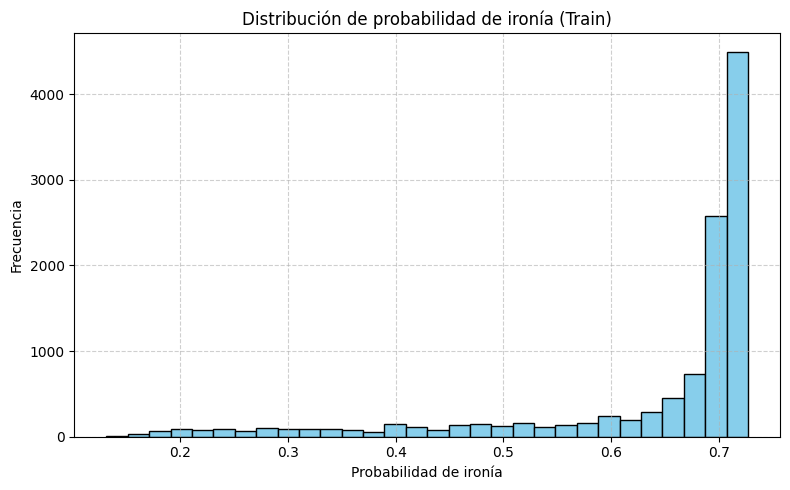

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.hist(ironia_train, bins=30, color='skyblue', edgecolor='black')
plt.title("Distribución de probabilidad de ironía (Train)")
plt.xlabel("Probabilidad de ironía")
plt.ylabel("Frecuencia")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [ ]:
ironia_binaria = []

for valor in ironia_train:
    if valor >= 0.7:
        ironia_binaria.append(1)
    else:
        ironia_binaria.append(0)

# Convertir a array de NumPy si lo necesitas
ironia_binaria = np.array(ironia_binaria)
ironia_binaria = []

for valor in ironia_train:
    if valor >= 0.85:
        ironia_binaria.append(1)
    else:
        ironia_binaria.append(0)

# Convertir a array de NumPy si lo necesitas
ironia_binaria = np.array(ironia_binaria)

In [ ]:
# Concatenamos con la probabilidad de ironía (que ya tienes)
X_train_final = np.hstack([proba_pos_train, ironia_train.reshape(-1, 1)])
X_test_final = np.hstack([proba_pos_test, ironia_test.reshape(-1, 1)])

In [ ]:
from xgboost import XGBClassifier

modelo_final = XGBClassifier(use_label_encoder=False, eval_metric='logloss', verbosity=0)
modelo_final.fit(X_train_final, y_train)
y_pred = modelo_final.predict(X_test_final)

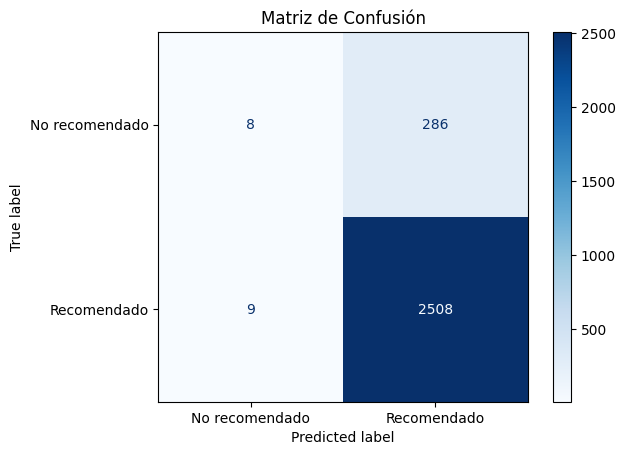

                precision    recall  f1-score   support

No recomendado       0.47      0.03      0.05       294
   Recomendado       0.90      1.00      0.94      2517

      accuracy                           0.90      2811
     macro avg       0.68      0.51      0.50      2811
  weighted avg       0.85      0.90      0.85      2811



In [ ]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=["No recomendado", "Recomendado"], cmap="Blues")
plt.title("Matriz de Confusión")
plt.show()

print(classification_report(y_test, y_pred, target_names=["No recomendado", "Recomendado"]))